In [152]:
# --- LIBRERIAS ---

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import glob
import os

In [153]:
# --- CONFIGURACIONES MODIFICABLES ---

# 1. RUTA A LOS DATOS
# Busca todos los archivos que terminen en '*_COMPENSADA.xlsx' en la carpeta 
# especificada y los almacena en una lista
data_path = 'data/raw/piezometers/'
piezometer_files = glob.glob(os.path.join(data_path, '*_COMPENSADA.xlsx'))

# Imprime los archivos encontrados
print(f'Archivos con datos piezometricos encontrados: {len(piezometer_files)}')
print(piezometer_files)

# 2. NOMBRES DE COLUMNAS
# Define un diccionario con nombres de columnas originales y a renombrar
columns_dict = {
    'TEMPERATURE' : 'Temperature_C',
    'NE_m' : 'Depth_m',
    'Cota_m' : 'Static_level_masl'
}

# Define una lista con con nombres de columnas no necesarias
columns_list = [
    'ms',
    'LEVEL',
    'P_baro'
]

# 3. CAMPANAS DE TERRENO
# Define un diccionario con el nombre y rango de fechas de cada campana.
# La fecha de termino es excluyente. Se consideran fechas de trabajo efectivo.
field_campaigns = {
    "May 2024": pd.date_range(start='2024-05-21', end='2024-05-23'),
    "Jul 2024": pd.date_range(start='2024-07-25', end='2024-07-28'),
    "Sep 2024": pd.date_range(start='2024-09-03', end='2024-09-07'),
    "Nov 2024": pd.date_range(start='2024-11-05', end='2024-11-12'),
    "Jan 2025": pd.date_range(start='2025-01-21', end='2025-01-23'),
    "Apr 2025": pd.date_range(start='2025-04-28', end='2025-05-02'),
    "Jul 2025": pd.date_range(start='2025-07-08', end='2025-07-16')
}

# 4. MAYOR INTERVALO DE MEDICION DE LOS DATALOGGERS
max_expected_interval='15min'

Archivos con datos piezometricos encontrados: 6
['data/raw/piezometers\\Data_08_11_2024_SDH2PS01_COMPENSADA.xlsx', 'data/raw/piezometers\\Data_15_07_2025_ SDH1PS01_COMPENSADA.xlsx', 'data/raw/piezometers\\Data_15_07_2025_ SDH1PS02_COMPENSADA.xlsx', 'data/raw/piezometers\\Data_15_07_2025_SDH2PP01_COMPENSADA.xlsx', 'data/raw/piezometers\\Data_15_07_2025_SDH2PS02_COMPENSADA.xlsx', 'data/raw/piezometers\\Data_15_07_2025_SDH2PS03_COMPENSADA.xlsx']


In [ ]:
# --- DEFINICION DE FUNCIONES ---

# 1. MANEJO DE FECHAS E INDICE

def timestamp_as_index(df):
    """Convierte las columnas 'Date' y 'Time' en un indice Datetime"""

    # Copia el df original
    df_copy = df.copy()

    # Convierte las columnas 'Date' y 'Time' en strings
    date_str = df_copy['Date'].astype(str)
    time_str = df_copy['Time'].astype(str)

    # Crea la columna 'Timestamps' con formato datetime a partir de 'Date' y 'Time'
    df_copy['Timestamps'] = pd.to_datetime(
        date_str + ' ' + time_str,
        format='%Y-%m-%d %H:%M:%S'
    )

    # Establece 'Timestamps' como indice
    df_copy = df_copy.set_index('Timestamps')

    # Elimina las columnas 'Date' y 'Time'
    df_copy = df_copy.drop(columns=['Date', 'Time'])

    print('Indice datetime establecido')
    return df_copy



# 2. FORMATEO DE COLUMNAS

def format_columns(df):
    """Renombra columnas y elimina las innecesarias"""
    df_formatted = df.rename(columns=columns_dict).drop(columns=columns_list, axis=1, errors='ignore')
    print('Nombres de columnas formateados')
    return df_formatted



# 3. IDENTIFICACION DE DATOS DUPLICADOS

def check_duplicates(df):
    """Revisa e informa sobre datos duplicados en el indice"""

    # Genera una serie booleana que almacena los indices duplicados como True
    duplicates = df.index.duplicated(keep=False)

    # Comprueba si la serie duplicates tiene algun valor True
    if not duplicates.any():
        print('No hay datos duplicados')
    # De haberlos, imprime el total y a cuales registros corresponde
    else:
        print(f'Hay {duplicates.sum()} datos duplicados:')
        print(df[duplicates])



# 4. IDENTIFICACION DE SALTOS REGULARES Y ANOMALOS EN LOS DATOS

def check_discontinuities(df, max_expected_interval):
    """Revisa e informa sobre saltos de tiempo en el indice"""
    
    # Genera una serie Timedelta que almcacena el tiempo transcurrido desde el registro anterior
    intervals = df.index.to_series().diff()

    # Genera una nueva serie con los Timedelta que superan un intervalo maximo esperado
    interval_anomalies = intervals[intervals > pd.Timedelta(max_expected_interval)]

    # Imprime los intervalos mas comunes y su frecuencia
    print(f'\nConteo de intervalos:\n{intervals.value_counts().head()}')

    # Comprueba si la serie interval_anomalies tiene algun valor
    if interval_anomalies.empty:
        print(f'\nNo hay intervalos anómalos')
    # De ser asi, imprime los registros con intervalos anomalos
    else:
        print(f'\nIntervalos anómalos:\n{interval_anomalies}')



# 5. REINDEXACION DE DATOS ENTRE INTERVALOS




# 6. IDENTIFICACION DE DATOS ANOMALOS DURANTE CAMPANAS DE TERRENO

def check_outliers(df, campaign_dates, well_name, campaign_name):
    """Identifica, informa y visualiza outliers en un rango de fechas"""

    # Hace una copia del df y lo filtra a las fechas de la campana de terreno
    df_copy = df.copy()
    df_campaign = df_copy.loc[campaign_dates.min() : campaign_dates.max()].copy()

    # Si no hay datos durante la campana se detiene la funcion
    if df_campaign.empty:
        print("No se encontraron datos para esta campana")
        return

    # Calcula el z-score de los valores de Temperature_C y Depth_m durante la campana
    df_campaign['z_temp'] = stats.zscore(df_campaign['Temperature_C'])
    df_campaign['z_depth'] = stats.zscore(df_campaign['Depth_m'])

    # Crea un df con registros que tengan z-scores > 3
    outlier_condition = (abs(df_campaign['z_temp']) > 3) | (abs(df_campaign['z_depth']) > 3)
    df_outliers = df_campaign[outlier_condition]

    # Comprueba si el df_outliers tiene algun valor anomalo
    if not df_outliers.empty:
        print("\nOutliers detectados:")
        print(df_outliers[['Temperature_C', 'Depth_m', 'z_temp', 'z_depth']])
    else:
        print("\nNo se encontraron valores con z-Score > 3 en esta campana.")

    # Grafica los valores normalizados de Temperature_C y Depth_m
    title = f"{well_name} - {campaign_name}"
    ax = df_campaign[['z_temp', 'z_depth']].plot(
        figsize=(10, 4),
        title=title,
        grid=True
    )
    ax.axhline(3, color='r', linestyle='--', lw=0.8)
    ax.axhline(-3, color='r', linestyle='--', lw=0.8)
    ax.set_ylabel('Z-Score')
    ax.set_xlabel('')
    plt.show()


# 7. CORRECCION DE DATOS ANOMALOS DURANTE CAMPANAS DE TERRENO





POZO: SDH2PS01
Archivo: Data_08_11_2024_SDH2PS01_COMPENSADA.xlsx

Rango de fechas: 2024-11-10 19:00:00 - 2025-07-15 11:50:00

--- Lectura y formateo de datos ---
Indice datetime establecido
Nombres de columnas formateados

--- Diagnostico de datos ---
No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:05:00    48291
1 days 00:05:00        2
Name: count, dtype: int64

Intervalos anómalos:
Timestamps
2024-07-26   1 days 00:05:00
2024-09-06   1 days 00:05:00
Name: Timestamps, dtype: timedelta64[ns]

--- Diagnostico campana May 2024---
Identificacion de outliers

---No se encontraron valores con z-Score > 3 en esta campana.


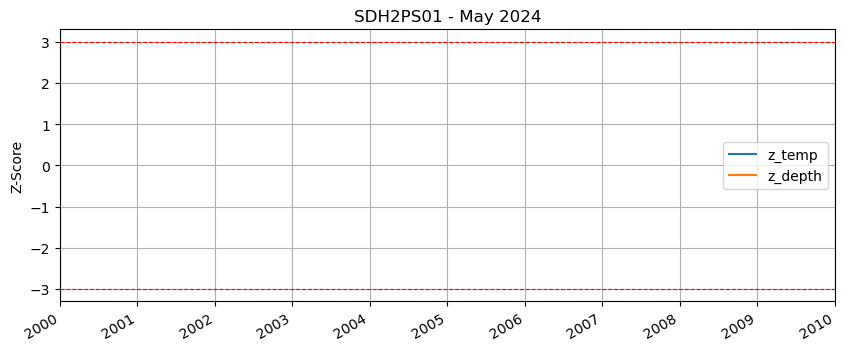


--- Diagnostico campana Jul 2024---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2024-07-26 00:00:00          1.499   0.1739 -4.185346 -0.073849
2024-07-26 00:05:00          1.501   0.1758 -4.097365  0.107637
2024-07-26 00:10:00          1.506   0.1753 -3.877413  0.059877
2024-07-26 00:15:00          1.507   0.1752 -3.833423  0.050325
2024-07-26 00:20:00          1.511   0.1753 -3.657461  0.059877
2024-07-26 00:25:00          1.510   0.1738 -3.701451 -0.083401
2024-07-26 00:30:00          1.512   0.1744 -3.613470 -0.026090
2024-07-26 00:35:00          1.514   0.1743 -3.525489 -0.035642
2024-07-26 00:40:00          1.516   0.1763 -3.437508  0.155396
2024-07-26 00:45:00          1.519   0.1750 -3.305537  0.031222
2024-07-26 00:50:00          1.521   0.1749 -3.217556  0.021670
2024-07-26 00:55:00          1.520   0.1736 -3.261546 -0.102505
2024-07-26 01:0

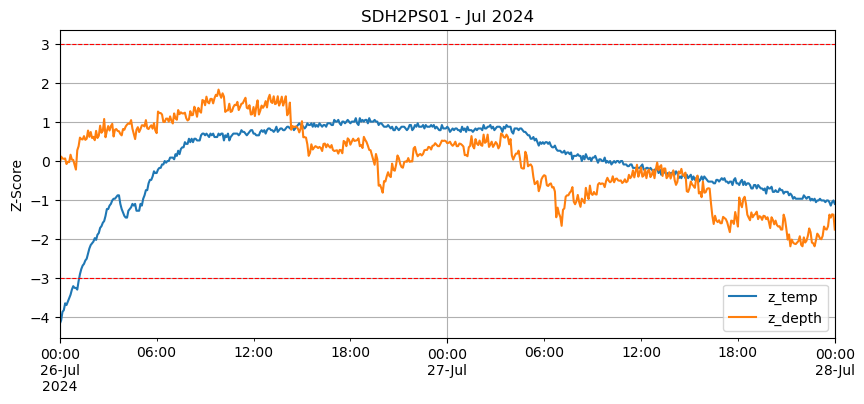


--- Diagnostico campana Sep 2024---
Identificacion de outliers

---No se encontraron valores con z-Score > 3 en esta campana.


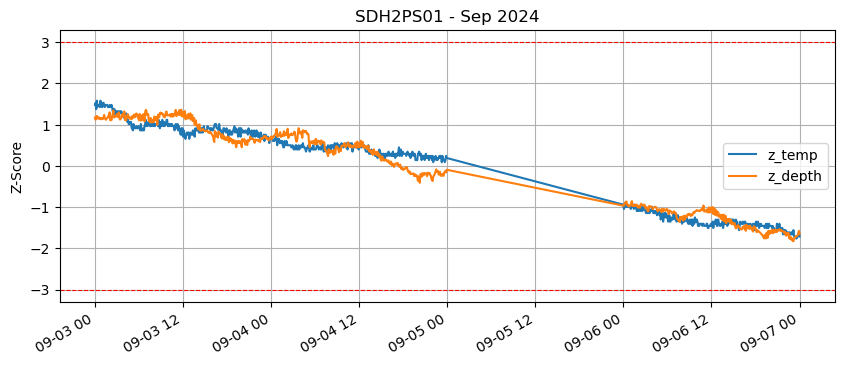


--- Diagnostico campana Nov 2024---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2024-11-05 14:50:00          0.640  -0.0422  -4.198298 -0.706509
2024-11-05 14:55:00          0.634  -0.0431  -4.601298 -0.819453
2024-11-05 15:00:00          0.610  -0.0418  -6.213299 -0.656311
2024-11-05 15:05:00          0.608  -0.0454  -6.347632 -1.108087
2024-11-05 15:10:00          0.581  -0.0438  -8.161133 -0.907298
2024-11-05 15:15:00          0.572  -0.0464  -8.765633 -1.233581
2024-11-05 15:20:00          0.556  -0.0464  -9.840300 -1.233581
2024-11-05 15:25:00          0.551  -0.0453 -10.176134 -1.095538
2024-11-05 15:30:00          0.556  -0.0414  -9.840300 -0.606114
2024-11-05 15:35:00          0.565  -0.0391  -9.235800 -0.317479
2024-11-05 15:40:00          0.570  -0.0385  -8.899967 -0.242183
2024-11-05 15:45:00          0.582  -0.0392  -8.093966 -0.330029
2

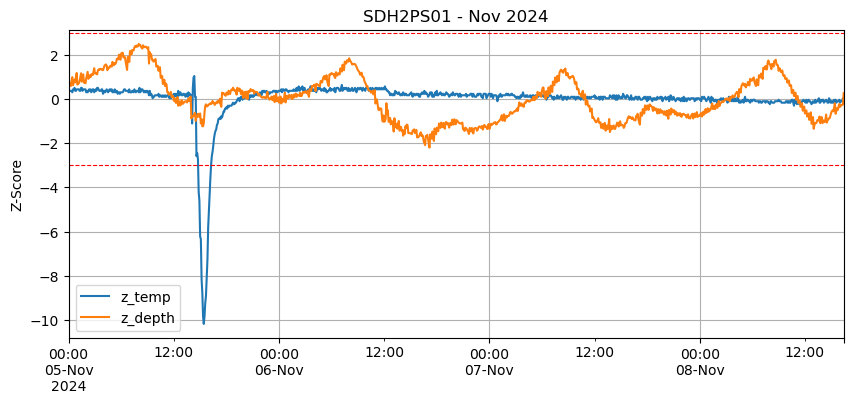


--- Diagnostico campana Jan 2025---
Identificacion de outliers
No se encontraron datos para esta campana

--- Diagnostico campana Apr 2025---
Identificacion de outliers
No se encontraron datos para esta campana

--- Diagnostico campana Jul 2025---
Identificacion de outliers
No se encontraron datos para esta campana

POZO: SDH1PS01
Archivo: Data_15_07_2025_ SDH1PS01_COMPENSADA.xlsx

Rango de fechas: 2024-05-23 00:00:00 - 2024-11-08 16:25:00

--- Lectura y formateo de datos ---
Indice datetime establecido
Nombres de columnas formateados

--- Diagnostico de datos ---
No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:10:00    35535
0 days 00:05:00    18344
0 days 00:15:00    10346
0 days 00:40:00        2
0 days 01:40:00        1
Name: count, dtype: int64

Intervalos anómalos:
Timestamps
2024-07-25 18:20:00   0 days 01:40:00
2024-09-05 14:00:00   0 days 00:40:00
2024-11-10 15:00:00   0 days 01:30:00
2025-01-22 14:00:00   0 days 00:40:00
Name: Timestamps, dtype: timedelta

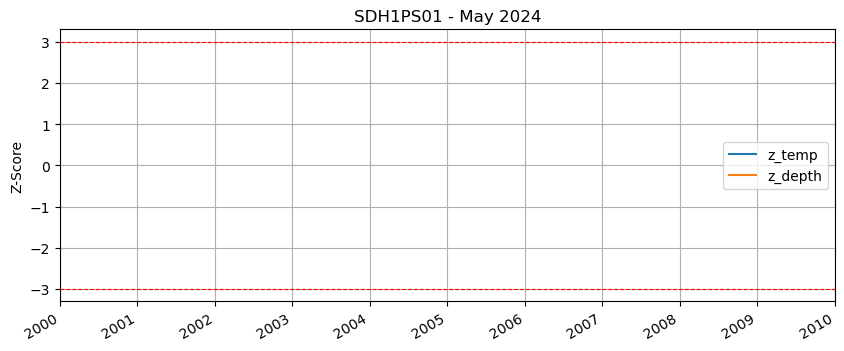


--- Diagnostico campana Jul 2024---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2024-07-25 18:20:00          8.767   0.5355  10.309266 -0.237084
2024-07-25 18:35:00          8.002   0.5352   7.710763 -0.247341
2024-07-25 18:50:00          7.600   0.5346   6.345275 -0.267857
2024-07-25 19:05:00          7.321   0.5335   5.397586 -0.305468
2024-07-25 19:20:00          7.129   0.5335   4.745412 -0.305468
2024-07-25 19:35:00          6.953   0.5327   4.147587 -0.332821
2024-07-25 19:50:00          6.800   0.5325   3.627886 -0.339660
2024-07-25 20:05:00          6.695   0.5321   3.271229 -0.353337


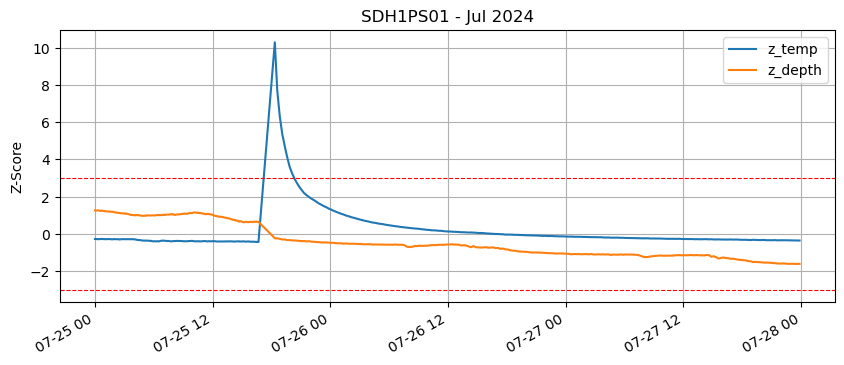


--- Diagnostico campana Sep 2024---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2024-09-05 14:00:00          5.560   0.1712  9.298518 -1.939779
2024-09-05 14:15:00          5.444   0.1735  5.700335 -1.760187
2024-09-05 14:30:00          5.389   0.1741  3.994300 -1.713337
2024-09-05 14:45:00          5.358   0.1737  3.032717 -1.744570


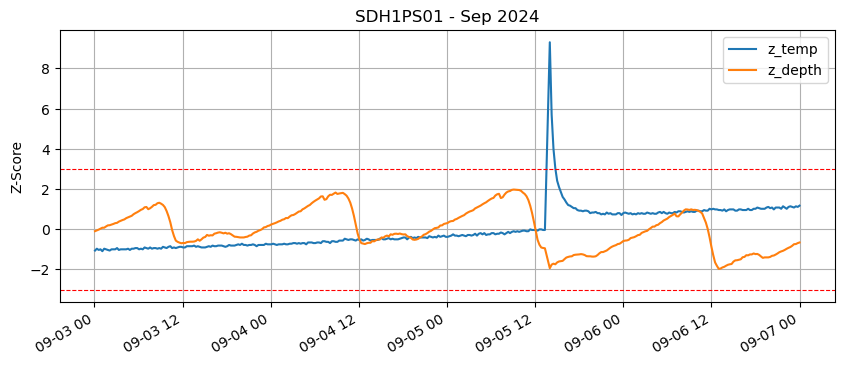


--- Diagnostico campana Nov 2024---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2024-11-10 15:00:00          6.464   0.5266  7.828068  0.095505
2024-11-10 15:10:00          6.353   0.5278  5.057720  0.256964
2024-11-10 15:20:00          6.299   0.5280  3.709983  0.283874


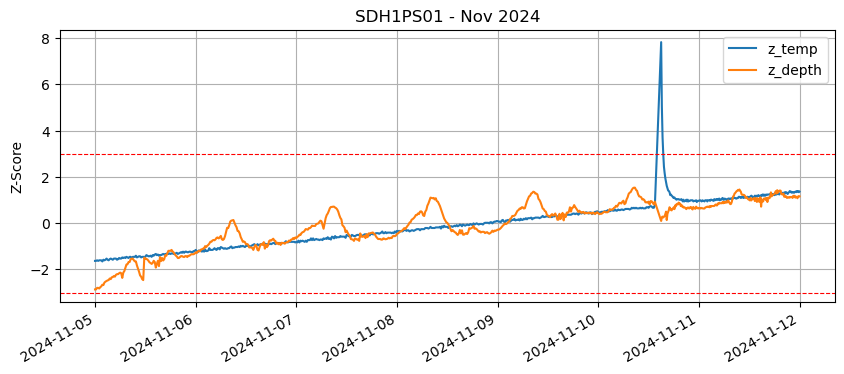


--- Diagnostico campana Jan 2025---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2025-01-22 14:00:00          9.608   0.5726  7.977386  1.105579
2025-01-22 14:10:00          9.529   0.5721  5.552346  0.788432
2025-01-22 14:20:00          9.484   0.5715  4.170995  0.407856
2025-01-22 14:30:00          9.455   0.5724  3.280790  0.978720


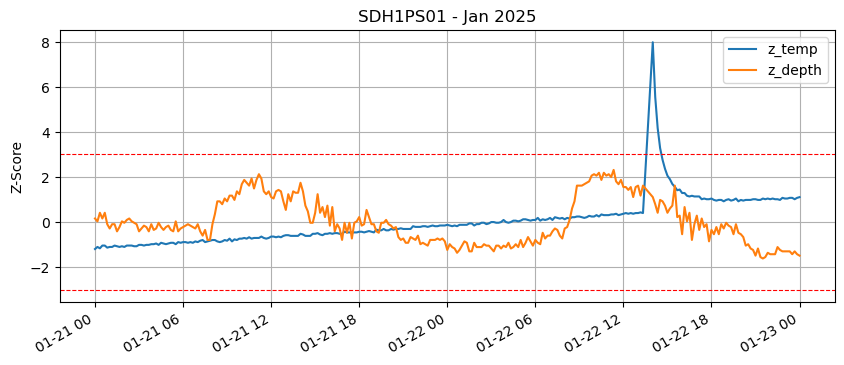


--- Diagnostico campana Apr 2025---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m     z_temp    z_depth
Timestamps                                                       
2025-04-30 17:20:00          9.449   1.2098  -1.591423  10.715198
2025-05-01 10:30:00         10.054   1.2009   0.093768  10.563477
2025-05-01 10:40:00         13.962   1.1965  10.979268  10.488468
2025-05-01 10:50:00         16.385   1.1960  17.728389  10.479945
2025-05-01 11:00:00         13.475   1.1945   9.622759  10.454374


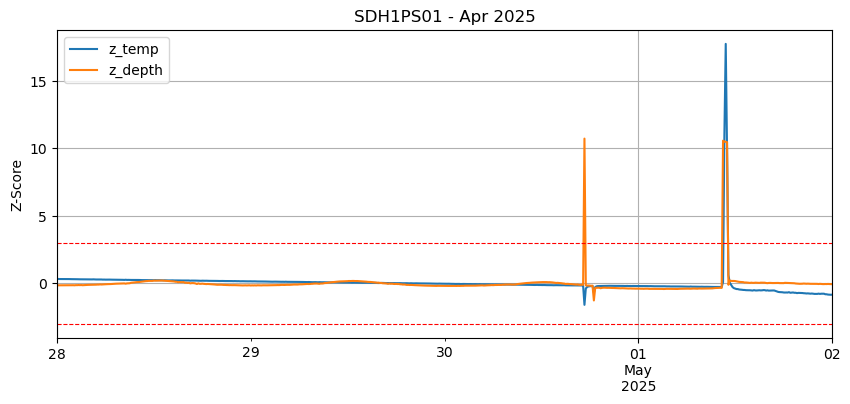


--- Diagnostico campana Jul 2025---
Identificacion de outliers

---No se encontraron valores con z-Score > 3 en esta campana.


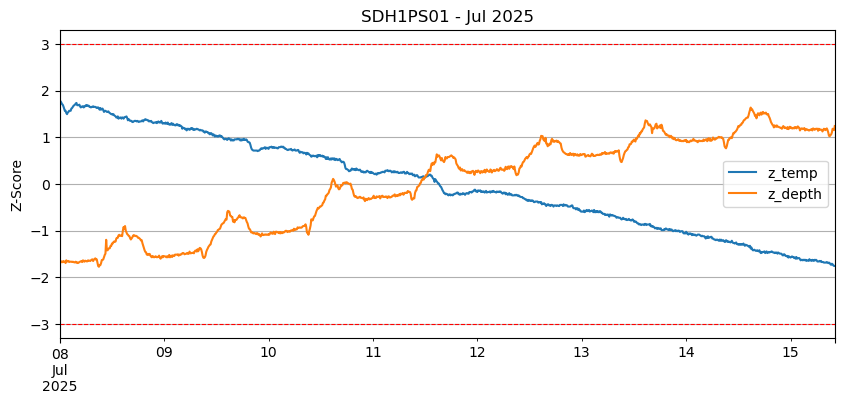


POZO: SDH1PS02
Archivo: Data_15_07_2025_ SDH1PS02_COMPENSADA.xlsx

Rango de fechas: 2024-05-23 00:00:00 - 2025-07-15 10:10:00

--- Lectura y formateo de datos ---
Indice datetime establecido
Nombres de columnas formateados

--- Diagnostico de datos ---
No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:10:00    35530
0 days 00:20:00        1
Name: count, dtype: int64

Intervalos anómalos:
Timestamps
2025-01-22 14:00:00   0 days 00:20:00
Name: Timestamps, dtype: timedelta64[ns]

--- Diagnostico campana May 2024---
Identificacion de outliers
No se encontraron datos para esta campana

--- Diagnostico campana Jul 2024---
Identificacion de outliers
No se encontraron datos para esta campana

--- Diagnostico campana Sep 2024---
Identificacion de outliers
No se encontraron datos para esta campana

--- Diagnostico campana Nov 2024---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                   

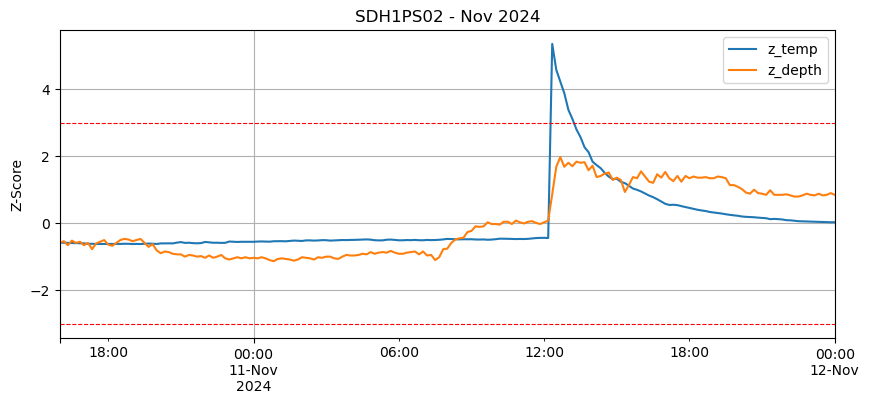


--- Diagnostico campana Jan 2025---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2025-01-22 14:00:00         12.384   0.6669  8.687195  1.739993
2025-01-22 14:10:00         12.196   0.6678  4.787034  2.109277
2025-01-22 14:20:00         12.118   0.6661  3.168881  1.411741


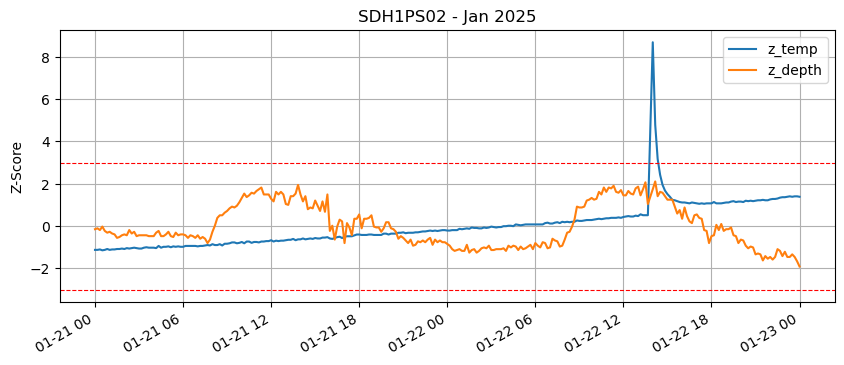


--- Diagnostico campana Apr 2025---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2025-04-30 17:30:00         13.483   0.6758  19.80143  1.615449


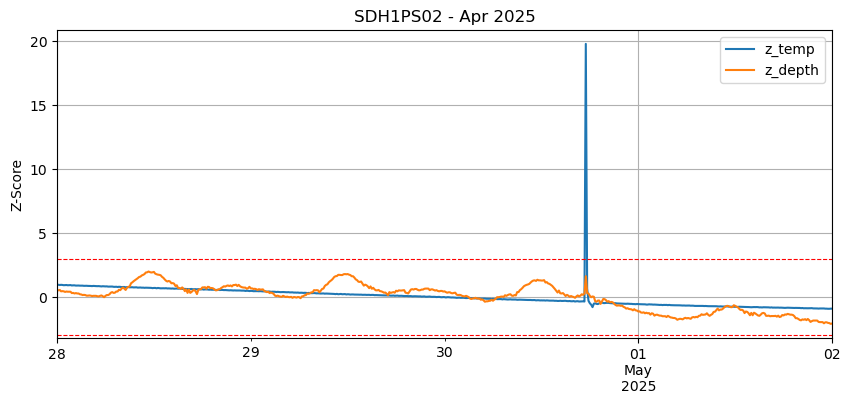


--- Diagnostico campana Jul 2025---
Identificacion de outliers

---No se encontraron valores con z-Score > 3 en esta campana.


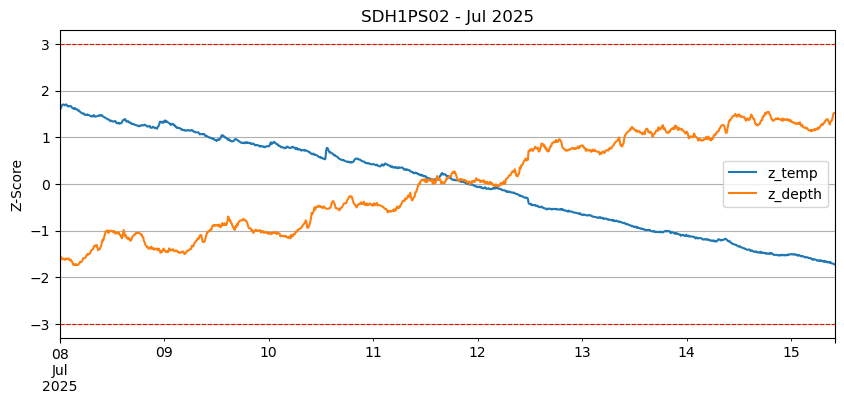


POZO: SDH2PP01
Archivo: Data_15_07_2025_SDH2PP01_COMPENSADA.xlsx

Rango de fechas: 2024-11-10 16:00:00 - 2025-07-15 10:00:00

--- Lectura y formateo de datos ---
Indice datetime establecido
Nombres de columnas formateados

--- Diagnostico de datos ---
No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:05:00    70160
0 days 00:10:00    14089
0 days 02:20:00        1
Name: count, dtype: int64

Intervalos anómalos:
Timestamps
2025-01-22 17:00:00   0 days 02:20:00
Name: Timestamps, dtype: timedelta64[ns]

--- Diagnostico campana May 2024---
Identificacion de outliers
No se encontraron datos para esta campana

--- Diagnostico campana Jul 2024---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2024-07-25 14:40:00          3.802  -0.1174 -3.270701 -4.455480
2024-07-25 14:45:00          3.805  -0.0420 -3.030399 -1.445349
2024-07-25 14:50:00      

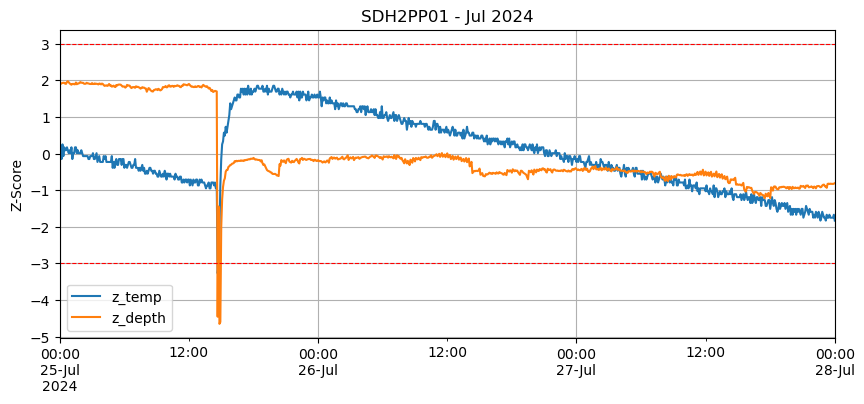


--- Diagnostico campana Sep 2024---
Identificacion de outliers

---No se encontraron valores con z-Score > 3 en esta campana.


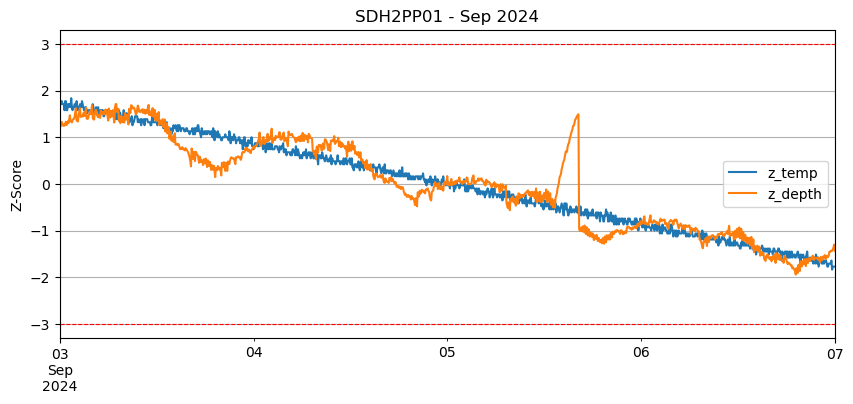


--- Diagnostico campana Nov 2024---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2024-11-10 12:05:00          2.525  -0.0958 -0.962563 -4.671711
2024-11-10 12:10:00          2.526  -0.0951 -0.881661 -4.598506
2024-11-10 12:15:00          2.525  -0.0948 -0.962563 -4.567132
2024-11-10 12:20:00          2.525  -0.0935 -0.962563 -4.431179
2024-11-10 12:25:00          2.526  -0.0930 -0.881661 -4.378890
2024-11-10 12:30:00          2.525  -0.0932 -0.962563 -4.399806
2024-11-10 12:35:00          2.526  -0.0918 -0.881661 -4.253395
2024-11-10 12:40:00          2.524  -0.0912 -1.043465 -4.190647
2024-11-10 12:45:00          2.525  -0.0905 -0.962563 -4.117442
2024-11-10 12:50:00          2.525  -0.0886 -0.962563 -3.918742
2024-11-10 12:55:00          2.523  -0.0876 -1.124367 -3.814163
2024-11-10 13:00:00          2.526  -0.0867 -0.881661 -3.720041
2024-11-10 13:0

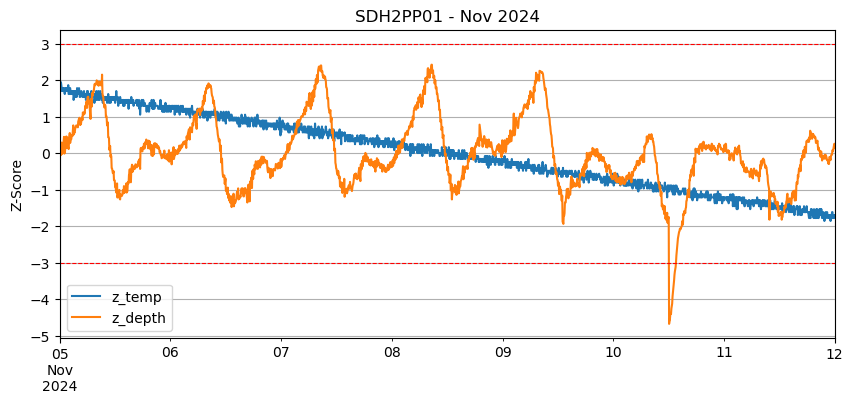


--- Diagnostico campana Jan 2025---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2025-01-22 17:00:00          3.610   0.3983  7.482801 -2.405392
2025-01-22 17:10:00          3.579   0.3984  6.019887 -2.393196
2025-01-22 17:20:00          3.556   0.4012  4.934500 -2.051723
2025-01-22 17:30:00          3.541   0.4005  4.226639 -2.137091
2025-01-22 17:40:00          3.531   0.4003  3.754731 -2.161482
2025-01-22 17:50:00          3.521   0.4018  3.282823 -1.978550


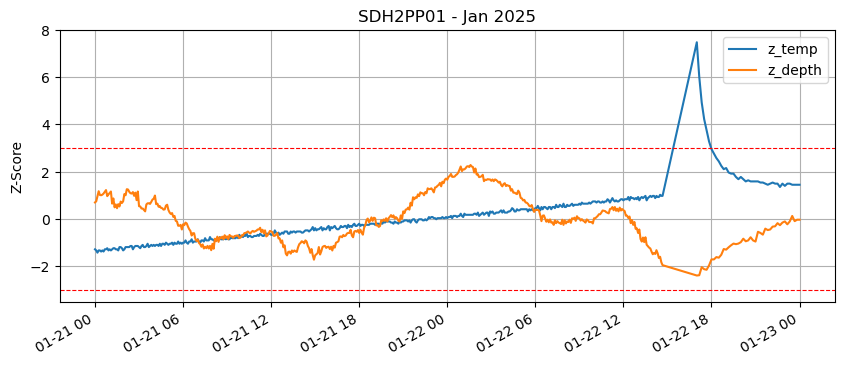


--- Diagnostico campana Apr 2025---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m     z_temp    z_depth
Timestamps                                                       
2025-04-30 13:10:00         21.002   2.1788  19.154981  18.850889


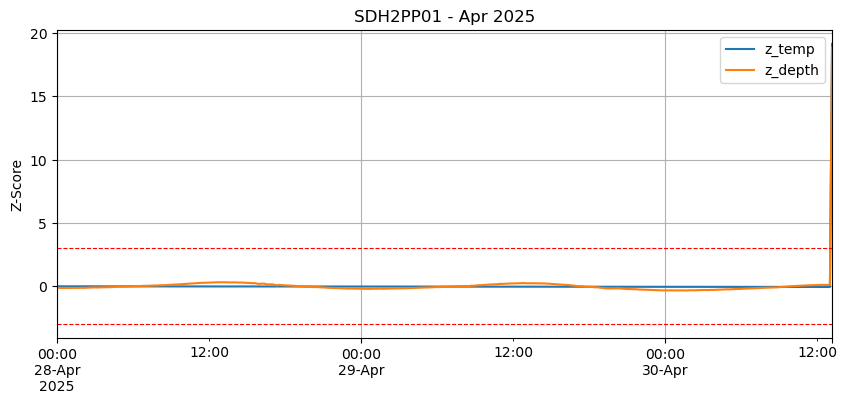


--- Diagnostico campana Jul 2025---
Identificacion de outliers
No se encontraron datos para esta campana

POZO: SDH2PS02
Archivo: Data_15_07_2025_SDH2PS02_COMPENSADA.xlsx

Rango de fechas: 2024-05-24 00:00:00 - 2025-04-30 13:10:00

--- Lectura y formateo de datos ---
Indice datetime establecido
Nombres de columnas formateados

--- Diagnostico de datos ---
No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:10:00    35520
0 days 00:40:00        1
Name: count, dtype: int64

Intervalos anómalos:
Timestamps
2025-01-22 16:00:00   0 days 00:40:00
Name: Timestamps, dtype: timedelta64[ns]

--- Diagnostico campana May 2024---
Identificacion de outliers
No se encontraron datos para esta campana

--- Diagnostico campana Jul 2024---
Identificacion de outliers
No se encontraron datos para esta campana

--- Diagnostico campana Sep 2024---
Identificacion de outliers
No se encontraron datos para esta campana

--- Diagnostico campana Nov 2024---
Identificacion de outliers

---Outliers 

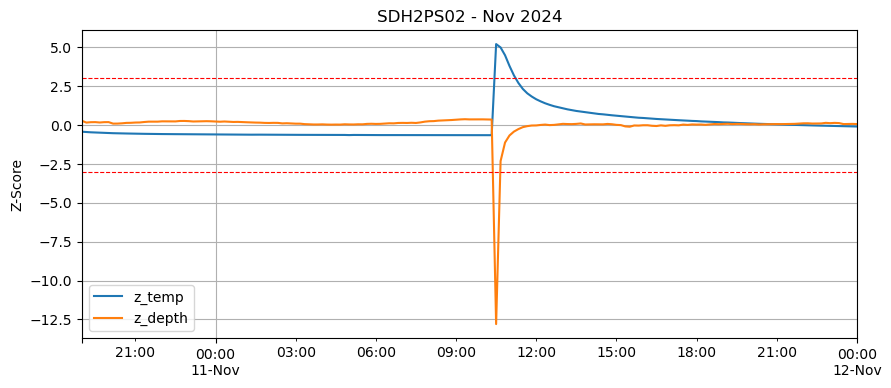


--- Diagnostico campana Jan 2025---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2025-01-22 16:00:00         10.891   1.3563  10.509199  1.713817
2025-01-22 16:10:00         10.766   1.3557   7.077957  1.606080
2025-01-22 16:20:00         10.700   1.3559   5.266261  1.641992
2025-01-22 16:30:00         10.658   1.3556   4.113363  1.588124
2025-01-22 16:40:00         10.628   1.3545   3.289865  1.390605


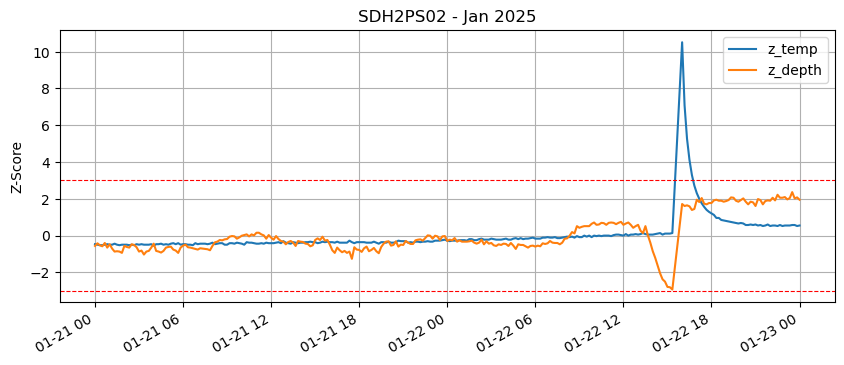


--- Diagnostico campana Apr 2025---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2025-04-30 13:30:00         18.495   1.3715  23.326213  3.844176


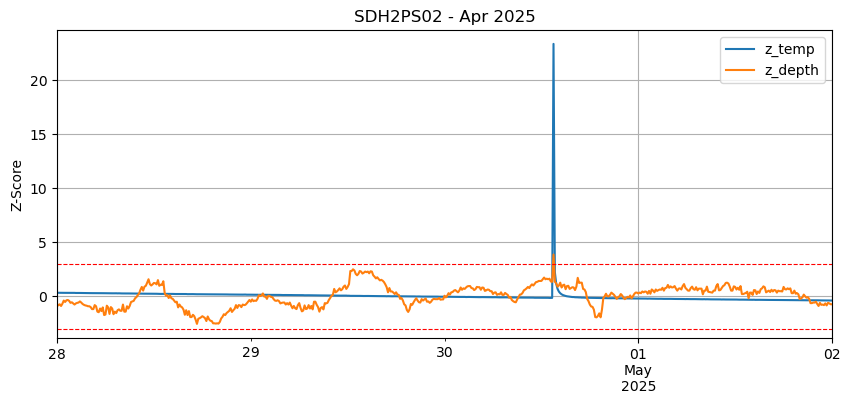


--- Diagnostico campana Jul 2025---
Identificacion de outliers

---No se encontraron valores con z-Score > 3 en esta campana.


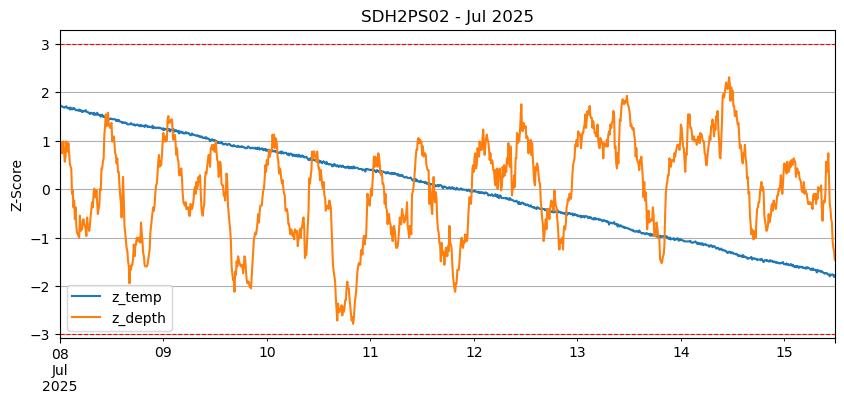


POZO: SDH2PS03
Archivo: Data_15_07_2025_SDH2PS03_COMPENSADA.xlsx

Rango de fechas: 2024-11-10 19:00:00 - 2025-07-15 11:40:00

--- Lectura y formateo de datos ---
Indice datetime establecido
Nombres de columnas formateados

--- Diagnostico de datos ---
No hay datos duplicados

Conteo de intervalos:
Timestamps
0 days 00:10:00    35522
0 days 00:30:00        1
Name: count, dtype: int64

Intervalos anómalos:
Timestamps
2025-01-22 16:00:00   0 days 00:30:00
Name: Timestamps, dtype: timedelta64[ns]

--- Diagnostico campana May 2024---
Identificacion de outliers
No se encontraron datos para esta campana

--- Diagnostico campana Jul 2024---
Identificacion de outliers
No se encontraron datos para esta campana

--- Diagnostico campana Sep 2024---
Identificacion de outliers
No se encontraron datos para esta campana

--- Diagnostico campana Nov 2024---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                    

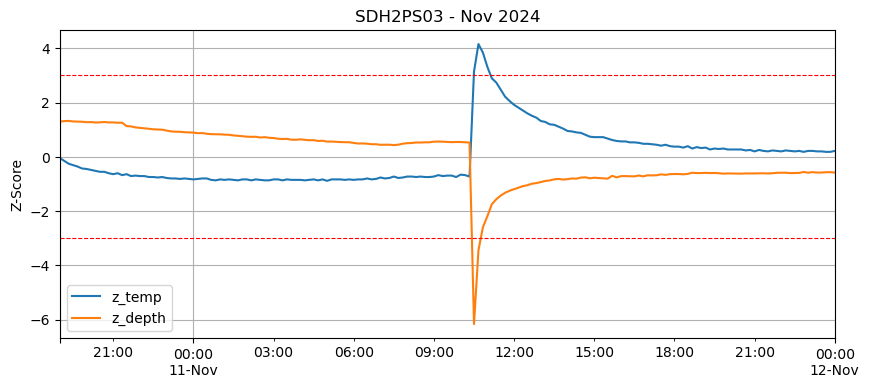


--- Diagnostico campana Jan 2025---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2025-01-22 14:40:00         10.187   0.8874   0.116692 -3.050475
2025-01-22 14:50:00         10.190   0.8863   0.215290 -3.365625
2025-01-22 15:00:00         10.185   0.8842   0.050960 -3.967275
2025-01-22 15:10:00         10.190   0.8844   0.215290 -3.909975
2025-01-22 15:20:00         10.188   0.8835   0.149558 -4.167825
2025-01-22 15:30:00         10.187   0.8825   0.116692 -4.454325
2025-01-22 16:00:00         10.500   0.9021  10.403768  1.161073
2025-01-22 16:10:00         10.390   0.9022   6.788501  1.189723
2025-01-22 16:20:00         10.335   0.9050   4.980868  1.991923
2025-01-22 16:30:00         10.301   0.9013   3.863422  0.931873
2025-01-22 16:40:00         10.280   0.9011   3.173235  0.874573


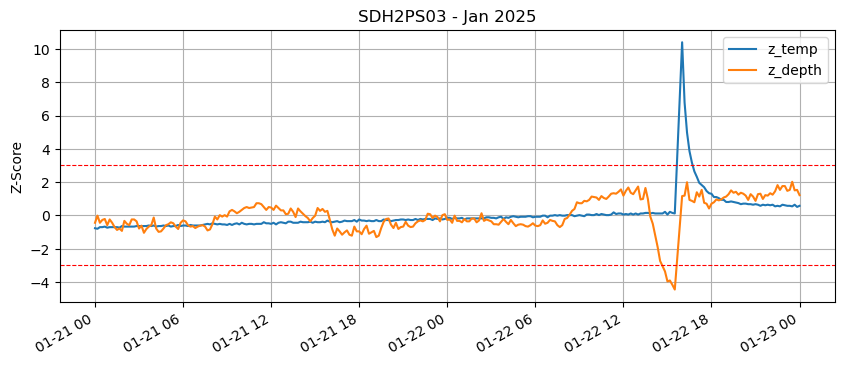


--- Diagnostico campana Apr 2025---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m     z_temp   z_depth
Timestamps                                                      
2025-04-30 13:40:00         10.911   0.9066  12.860820  1.156545
2025-04-30 13:50:00         10.323   0.9061   4.777112  0.962227


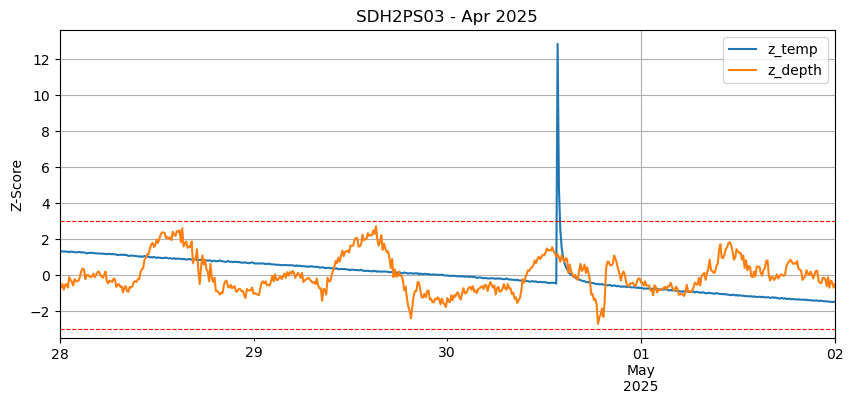


--- Diagnostico campana Jul 2025---
Identificacion de outliers

---Outliers detectados:
                     Temperature_C  Depth_m    z_temp   z_depth
Timestamps                                                     
2025-07-10 16:00:00          7.080   0.8834  0.384144 -3.075321
2025-07-10 16:10:00          7.079   0.8829  0.368362 -3.235400
2025-07-10 16:20:00          7.080   0.8829  0.384144 -3.235400
2025-07-10 16:30:00          7.081   0.8830  0.399925 -3.203384
2025-07-10 16:40:00          7.083   0.8835  0.431488 -3.043305
2025-07-10 16:50:00          7.086   0.8836  0.478832 -3.011290
2025-07-10 17:00:00          7.086   0.8836  0.478832 -3.011290


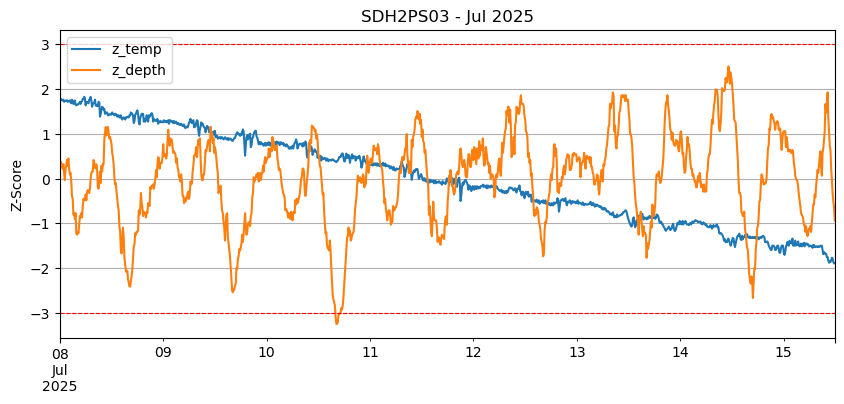

In [155]:
# --- BUCLE DE PROCESAMIENTO ---

# Bucle externo: itera sobre cada pozo
# file_path refiere a cada valor de la lista piezometer_files
for file_path in piezometer_files:
    
    # Define el nombre de cada pozo usando el nombre de archivo.
    # Mantiene la penultima cadena de texto, separadas por guion bajo
    base_name = os.path.basename(file_path)
    well_name = base_name.split('_')[-2].strip()
    
    # Imprime un titulo que indica el nombre del pozo y de archivo
    print("\n" + "="*80)
    print(f"POZO: {well_name}")
    print(f"Archivo: {os.path.basename(file_path)}")
    print("="*80)

    # Imprime el rango temporal de los datos disponibles
    print(f"\nRango de fechas: {df_processed.index.min()} - {df_processed.index.max()}")

    # Aplica las funciones de formateo de fechas y columnas
    print("\n--- Lectura y formateo de datos ---")
    try:
        df_raw = pd.read_excel(file_path)
        df_processed = timestamp_as_index(df_raw)
        df_processed = format_columns(df_processed)

    # En caso de error, avisa cual archivo no se pudo procesar y continua el bucle  
    except:
        print(f"ERROR: No se pudo procesar el archivo {file_path}")
        continue

    # Aplica las funciones de diagnostico de datos aplicables a todo el archivo
    print("\n--- Diagnostico de datos ---")
    check_duplicates(df_processed)
    check_discontinuities(df_processed, max_expected_interval)

    # Bucle interno: itera sobre las campanas de terreno. 
    # name y dates refieren a los pares de valores almacenados en el diccionario field_campaigns
    for campaing_name, campaign_dates in field_campaigns.items():

        # Imprime el nombre de la campana
        print(f"\n--- Diagnostico campana {campaing_name}---")

        # Aplica la funcion de identificacion de outliers
        print("Identificacion de outliers")
        check_outliers(df_processed, campaign_dates, well_name, campaing_name)

In [ ]:
# --- BUCLE DE PROCESAMIENTO ---

for file_path in piezometer_files:

    well_name = os.path.basename(file_path).split('_')[2]

    

In [3]:
# Definir la ruta de los datos

# Sitio norte
fp_sdh1_ps01 = 'data/raw/piezometers/Data_15_07_2025_ SDH1PS01_COMPENSADA.xlsx'
fp_sdh1_ps02 = 'data/raw/piezometers/Data_15_07_2025_ SDH1PS02_COMPENSADA.xlsx'

In [4]:
# Leer los datos

# Sitio norte
sdh1_ps01 = pd.read_excel(fp_sdh1_ps01)
sdh1_ps02 = pd.read_excel(fp_sdh1_ps02)

In [ ]:
# Función para crear una columna 'Timestamps' y usarla como indice con formato datetime

def timestamp_as_index(dataframe):

    # Convertir las columnas 'Date' y 'Time' en strings
    date_str = dataframe['Date'].astype(str)
    time_str = dataframe['Time'].astype(str)
    # Crear columna 'Timestamps' con formato datetime
    dataframe['Timestamps'] = pd.to_datetime(
        date_str + ' ' + time_str,
        format='%Y-%m-%d %H:%M:%S'
    )

    # Establecer 'Timestamps' como indice
    dataframe = dataframe.set_index('Timestamps')
    
    # Eliminar columnas 'Date' y 'Time'
    dataframe = dataframe.drop(columns=['Date', 'Time'])

    return dataframe

In [6]:
# Ejecutar funcion para establecer 'Timestamps' como indice
sdh1_ps01 = timestamp_as_index(sdh1_ps01)
sdh1_ps02 = timestamp_as_index(sdh1_ps02)

In [7]:
# Diccionario con nombres de columnas originales y renombradas
columns_dict = {
    'TEMPERATURE' : 'Temperature_C',
    'NE_m' : 'Depth_m',
    'Cota_m' : 'Static_level_masl'
}

# Lista con nombres de columnas no necesarias
columns_list = [
    'ms',
    'LEVEL',
    'P_baro'
]

In [8]:
# Funcion para renombrar columnas y eliminar las innecesarias

def format_columns(df):
    df = df.rename(columns=columns_dict).drop(columns=columns_list, axis=1, errors='ignore')
    return df

In [9]:
# Ejecutar la función de formateo de columnas

sdh1_ps01 = format_columns(sdh1_ps01)
sdh1_ps02 = format_columns(sdh1_ps02)

In [10]:
# Función para detectar datos duplicados
def check_duplicates(df, df_name):

    # Hace una copia del df
    df_copy = df.copy()

    # Genera una columna que almacena los registros duplicados como True
    df_copy['duplicated'] = df_copy.index.duplicated(keep=False)

    # Filtra la copia del df, manteniendo sólo los registros duplicados
    dup_filter = df_copy[df_copy['duplicated'] == True]

    # Si los hay, imprime cuántos y cuáles registros están duplicados
    if dup_filter.empty:
        print(f'No hay datos duplicados en {df_name}')
    else:
        print(f'{df_name} tiene {len(dup_filter)} datos duplicados:')
        print(dup_filter)

In [11]:
# Aplicar función de detección de duplicados
check_duplicates(sdh1_ps01, 'sdh_ps01')
check_duplicates(sdh1_ps02, 'sdh_ps02')

No hay datos duplicados en sdh_ps01
No hay datos duplicados en sdh_ps02


In [12]:
# Función para detectar intervalos de medición y/o saltos en los datos
def check_discontinuities(df, df_name, max_expected_interval):

    # Hace una copia del df
    df_copy = df.copy()

    # Genera una columna que almacena los intervalos entre datos como Timedelta
    df_copy['diff'] = df_copy.index.diff()

    # Genera un objeto con el conteo de valores en la columna diff
    value_count = df_copy['diff'].value_counts()

    # Genera un objeto con los registros con intervalos superiores a los esperados
    discontinuities = df_copy[df_copy['diff'] > pd.Timedelta(max_expected_interval)]

    # Imprime el resultado del conteo de valores
    print(f'Los intervalos entre datos en {df_name} son: {value_count}')
    print('')

    # Imprime los registros que superan el intervalo máximo esperado
    print(f'Los intervalos anómalos en {df_name} son: {discontinuities}')
    print('')

In [13]:
check_discontinuities(sdh1_ps01, 'sdh1_ps01', '15min')
check_discontinuities(sdh1_ps02, 'sdh1_ps02', '15min')

Los intervalos entre datos en sdh1_ps01 son: diff
0 days 00:10:00    35535
0 days 00:05:00    18344
0 days 00:15:00    10346
0 days 00:40:00        2
0 days 01:40:00        1
0 days 01:30:00        1
Name: count, dtype: int64

Los intervalos anómalos en sdh1_ps01 son:                      Temperature_C  Depth_m  Static_level_masl            diff
Timestamps                                                                    
2024-07-25 18:20:00          8.767   0.5355          3827.0645 0 days 01:40:00
2024-09-05 14:00:00          5.560   0.1712          3827.4288 0 days 00:40:00
2024-11-10 15:00:00          6.464   0.5266          3827.0734 0 days 01:30:00
2025-01-22 14:00:00          9.608   0.5726          3827.0274 0 days 00:40:00

Los intervalos entre datos en sdh1_ps02 son: diff
0 days 00:10:00    35530
0 days 00:20:00        1
Name: count, dtype: int64

Los intervalos anómalos en sdh1_ps02 son:                      Temperature_C  Depth_m  Static_level_masl            diff
Timestam

In [ ]:
# Reindexar datos entre intervalos de medición regulares

In [90]:
# Fechas de terreno efectivo (trabajadas en el SDH)
# La fecha de término es excluyente
may_2024 = pd.date_range(start='2024-05-21', end='2024-05-23')
jul_2024 = pd.date_range(start='2024-07-25', end='2024-07-28')
sep_2024 = pd.date_range(start='2024-09-03', end='2024-09-07')
nov_2024 = pd.date_range(start='2024-11-05', end='2024-11-12')
jan_2025 = pd.date_range(start='2025-01-21', end='2025-01-23')
apr_2025 = pd.date_range(start='2025-04-28', end='2025-05-02')
jul_2025 = pd.date_range(start='2025-07-08', end='2025-07-16')


a_2025 = pd.date_range(start='2024-05-01', end='2025-07-31')

In [117]:
# Funcion que identifica los outliers en las columnas Temperature_C o Depth_m
# durante los días de terreno

def check_outliers(df, field_campaign):

    # Copia el df
    df_copy = df.copy()

    # Filtra el df a los dias en terreno
    df_copy = df_copy[field_campaign.min() : field_campaign.max()]

    # Calcula el z-score de Temperature_C y Depth_m
    df_copy['z_temp'] = stats.zscore(df_copy['Temperature_C'])
    df_copy['z_depth'] = stats.zscore(df_copy['Depth_m'])

    # Filtra los valores que tengan z-scores > 3
    outliers = df_copy[(abs(df_copy['z_temp']) > 3) | (abs(df_copy['z_depth']) > 3)]

    # Grafica los valores normalizados de Temperature_C y Depth_m
    plot = df_copy[['z_depth', 'z_temp']].plot()

    # Imprime los registros con valores detectados como outliers
    print(outliers)
    
    # Grafica los datos normalizados durante la campaña de terreno
    print(plot)

                     Temperature_C  Depth_m  Static_level_masl     z_temp  \
Timestamps                                                                  
2025-04-30 17:20:00          9.449   1.2098          3826.3902  -1.591423   
2025-05-01 10:30:00         10.054   1.2009          3826.3991   0.093768   
2025-05-01 10:40:00         13.962   1.1965          3826.4035  10.979268   
2025-05-01 10:50:00         16.385   1.1960          3826.4040  17.728389   
2025-05-01 11:00:00         13.475   1.1945          3826.4055   9.622759   

                       z_depth  
Timestamps                      
2025-04-30 17:20:00  10.715198  
2025-05-01 10:30:00  10.563477  
2025-05-01 10:40:00  10.488468  
2025-05-01 10:50:00  10.479945  
2025-05-01 11:00:00  10.454374  
Axes(0.125,0.11;0.775x0.77)
Empty DataFrame
Columns: [Temperature_C, Depth_m, Static_level_masl, z_temp, z_depth]
Index: []
Axes(0.125,0.11;0.775x0.77)


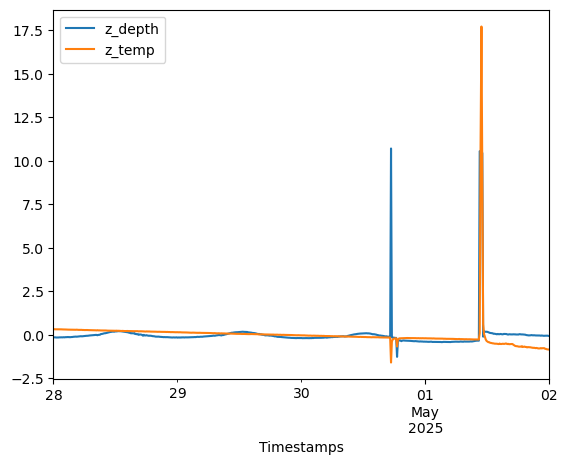

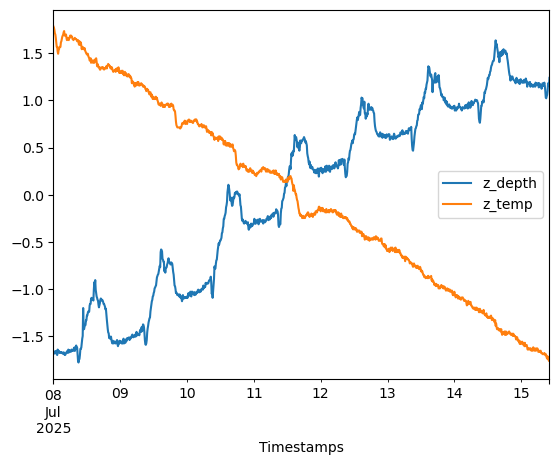

In [118]:
check_outliers(sdh1_ps01, apr_2025)
check_outliers(sdh1_ps01, jul_2025)